In [ ]:
import sys  
sys.path.insert(0, "C:\\Users\\Nuzha\\Desktop\\Mask_RCNN-master")

from mrcnn.config import Config
from mrcnn import model as modellib
from mrcnn import visualize
import mrcnn
from mrcnn.utils import Dataset
from mrcnn.model import MaskRCNN
import numpy as np
from numpy import zeros
from numpy import asarray
import colorsys
import argparse
import imutils
import random
import cv2
import os
import time
from matplotlib import pyplot
from matplotlib.patches import Rectangle
from keras.models import load_model
%matplotlib inline
from os import listdir
from xml.etree import ElementTree

Using TensorFlow backend.


In [ ]:
class myMaskRCNNConfig(Config):
    # give the configuration a recognizable name
    NAME = "MaskRCNN_config"
 
    # set the number of GPUs to use along with the number of images
    # per GPU
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
 
    # number of classes (we would normally add +1 for the background)
     # kangaroo + BG
    NUM_CLASSES = 6+1
    
    # Number of training steps per epoch 131
    STEPS_PER_EPOCH = 200
    
    # Learning rate
    LEARNING_RATE=0.006
    
    # Skip detections with < 80% confidence
    DETECTION_MIN_CONFIDENCE = 0.8
    
    # setting Max ground truth instances
    MAX_GT_INSTANCES=10

In [ ]:
config = myMaskRCNNConfig()

In [ ]:
config.display()


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        60
DETECTION_MIN_CONFIDENCE       0.8
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                19
IMAGE_MIN_DIM                  512
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.006
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE           

In [ ]:
import csv
import pandas as pd
class CustomDataset1(Dataset):
    # load the dataset definitions
    def load_dataset(self, dataset_dir, is_train=True):
        
        # Add classes. We have only one class to add.
        self.add_class("field", 1, "Name")
        self.add_class("field", 2, "FatherName")
        self.add_class("field", 3, "Gender")
        self.add_class("field", 4, "CountryOfStay")
        self.add_class("field", 5, "IdentityNumber")
        self.add_class("field", 6, "DOB")
        #self.add_class("field", 7, "Pakistan_CNIC")
        #self.add_class("field", 8, "Surname")
        #self.add_class("field", 9, "GivenName")
        #self.add_class("field", 10, "Nationality")
        #self.add_class("field", 11, "singaporePassport")
        #self.add_class("field", 12, "PlaceOfBirth")
        #self.add_class("field", 13, "nationalID")
        #self.add_class("field", 14, "Surname")
        #self.add_class("field", 15, "FirstName")
        #self.add_class("field", 16, "UKPassport")


        
        # define data locations for images and annotations
        images_dir = dataset_dir + "\\images"
        annotations_dir = dataset_dir + "\\annots"
        
        # Iterate through all files in the folder to 
        #add class, images and annotaions
        i = 0
        for filename in listdir(images_dir):
            i = i+1
            #extract image id(filename)
            image_id = filename
            
            # skip bad images
            #if image_id in ['00090']:
                #continue
            # skip all images after 150 if we are building the train set
            if is_train and i >= 1701:
                continue
            # skip all images before 150 if we are building the test/val set
            if not is_train and i < 1701:
                continue
            
            # setting image file
            img_path = images_dir + "\\" + filename
            
            # setting annotations file
            ann_path = annotations_dir + "\\all_labels_pakistan_cnic.csv"
            
            # adding images and annotations to dataset
            self.add_image('field', image_id=image_id, path=img_path, annotation=ann_path)

# extract bounding boxes from an annotation file
    def extract_boxes(self, filename, image_id):
        
        with open(filename, 'r') as csv_file:
          width = 0
          height = 0
          df = pd.read_csv(csv_file)
          info = self.image_info[image_id]
          id_ = info['id']
          #print("imageID= ", id_)

          img = df.loc[df['filename'] == id_]
          #print("img= ", img)
          # extract each bounding box
          boxes = list()
          for index, row in img.iterrows():
            if not np.isnan(row['ymin']) and not np.isnan(row['ymax']) and row['class']!='Pakistan_CNIC':
                xmin = row['xmin']
                ymin = row['ymin']
                xmax = row['xmax']
                ymax = row['ymax']
                class_name = row['class']
                #print("className= ", class_name)
                class_id = self.class_names.index(class_name)
                #print("class_ID= ", class_id)
                coors = [xmin, ymin, xmax, ymax, class_id]
                boxes.append(coors)
                # extract image dimensions
                width = row['width']
                height = row['height']

        return boxes, width, height

# load the masks for an image
    """Generate instance masks for an image.
       Returns:
        masks: A bool array of shape [height, width, instance count] with
            one mask per instance.
        class_ids: a 1D array of class IDs of the instance masks.
     """
    def load_mask(self, image_id):
        # get details of image
        info = self.image_info[image_id]
        #print("info= ", info)
        
        # define anntation  file location
        path = info['annotation']
        
        # load XML
        boxes, w, h = self.extract_boxes(path, image_id)
       
        # create one array for all masks, each on a different channel
        masks = zeros([h, w, len(boxes)], dtype='uint8')
        
        # create masks
        class_ids = list()
        for i in range(len(boxes)):
            box = boxes[i]
            row_s, row_e = box[1], box[3]
            col_s, col_e = box[0], box[2]
            #print("BOX", box)
            masks[round(row_s):round(row_e), round(col_s):round(col_e), i] = 1
            class_ids.append(box[4])
        
        print("c= ", class_ids)
        return masks, asarray(class_ids, dtype='int32')

# load an image reference
     #"""Return the path of the image."""
    def image_reference(self, image_id):
        info = self.image_info[image_id]
        print(info)
        return info['path']

In [ ]:
import csv
import pandas as pd
class CustomDataset2(Dataset):
    # load the dataset definitions
    def load_dataset(self, dataset_dir, is_train=True):
        
        
        # Add classes. We have 9 classes to add.
        self.add_class("field", 1, "Surname")
        self.add_class("field", 2, "GivenName")
        self.add_class("field", 3, "Nationality")
        self.add_class("field", 4, "DOB")
        self.add_class("field", 5, "Gender")
        self.add_class("field", 6, "FatherName")
        
        
        # define data locations for images and annotations
        images_dir = dataset_dir + "\\images"
        annotations_dir = dataset_dir + "\\annots"
        
        # Iterate through all files in the folder to 
        #add class, images and annotaions
        i = 0
        for filename in listdir(images_dir):
            i = i+1
            #extract image id(filename)
            image_id = filename
            
            # skip bad images
            #if image_id in ['00090']:
                #continue
            # skip all images after split point if we are building the train set
            if is_train and i >= 817:
                continue
            # skip all images before split point if we are building the test/val set
            if not is_train and i < 817:
                continue
            
            # setting image file
            img_path = images_dir + "\\" + filename
            
            # setting annotations file
            ann_path = annotations_dir + "\\all_labels_pakistan_passport.csv"
            
            # adding images and annotations to dataset
            self.add_image('field', image_id=image_id, path=img_path, annotation=ann_path)

# extract bounding boxes from an annotation file
    def extract_boxes(self, filename, image_id):
        
        with open(filename, 'r') as csv_file:
          width = 0
          height = 0
          df = pd.read_csv(csv_file)
          info = self.image_info[image_id]
          id_ = info['id']
          #print("imageID= ", id_)

          img = df.loc[df['filename'] == id_]
          #print("img= ", img)
          # extract each bounding box
          boxes = list()
          for index, row in img.iterrows():
            if not np.isnan(row['ymin']) and not np.isnan(row['ymax']):
                xmin = row['xmin']
                ymin = row['ymin']
                xmax = row['xmax']
                ymax = row['ymax']
                class_name = row['class']
                #print("className= ", class_name)
                class_id = self.class_names.index(class_name)
                #print("class_ID= ", class_id)
                coors = [xmin, ymin, xmax, ymax, class_id]
                boxes.append(coors)
                # extract image dimensions
                width = row['width']
                height = row['height']

        return boxes, width, height

# load the masks for an image
    """Generate instance masks for an image.
       Returns:
        masks: A bool array of shape [height, width, instance count] with
            one mask per instance.
        class_ids: a 1D array of class IDs of the instance masks.
     """
    def load_mask(self, image_id):
        # get details of image
        info = self.image_info[image_id]
        #print("info= ", info)
        
        # define anntation  file location
        path = info['annotation']
        
        # load XML
        boxes, w, h = self.extract_boxes(path, image_id)
       
        # create one array for all masks, each on a different channel
        masks = zeros([h, w, len(boxes)], dtype='uint8')
        
        # create masks
        class_ids = list()
        for i in range(len(boxes)):
            box = boxes[i]
            row_s, row_e = box[1], box[3]
            col_s, col_e = box[0], box[2]
            #print("BOX", box)
            masks[round(row_s):round(row_e), round(col_s):round(col_e), i] = 1
            class_ids.append(box[4])
        
        print("c= ", class_ids)
        return masks, asarray(class_ids, dtype='int32')

# load an image reference
     #"""Return the path of the image."""
    def image_reference(self, image_id):
        info = self.image_info[image_id]
        print(info)
        return info['path']

In [ ]:
# prepare train set
train_set = CustomDataset1()
train_set.load_dataset("C:\\Users\\Nuzha\\Desktop\\Dataset\\p_cnic", is_train=True)
train_set.prepare()
print('Train: %d' % len(train_set.image_ids))
# prepare test/val set
test_setc = CustomDataset1()
test_setc.load_dataset("C:\\Users\\Nuzha\\Desktop\\Dataset\\p_cnic", is_train=False)
test_setc.prepare()
print('Test: %d' % len(test_setc.image_ids))

Train: 1700
Test: 825


In [ ]:
# prepare train set
train_set = CustomDataset2()
train_set.load_dataset("C:\\Users\\Nuzha\\Desktop\\Dataset\\p_pass", is_train=True)
train_set.prepare()
print('Train: %d' % len(train_set.image_ids))
# prepare test/val set
test_setp = CustomDataset2()
test_setp.load_dataset("C:\\Users\\Nuzha\\Desktop\\Dataset\\p_pass", is_train=False)
test_setp.prepare()
print('Test: %d' % len(test_setp.image_ids))

Train: 816
Test: 396


In [ ]:
config.DETECTION_MIN_CONFIDENCE = 0.8

In [ ]:
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
#Loading the model in the inference mode
Cnic_model = modellib.MaskRCNN(mode="inference", config=config, model_dir='./')
# loading the trained weights o the custom dataset
Cnic_model.load_weights("C:\\Users\\Nuzha\\Desktop\\Mask_RCNN-master\\mask_rcnn_.1609581705.4424255.h5", by_name=True)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
box_ind is deprecated, use box_indices instead


Instructions for updating:
box_ind is deprecated, use box_indices instead


Instructions for updating:
Use `tf.cast` instead.


Instructions for updating:
Use `tf.cast` instead.


In [ ]:
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
#Loading the model in the inference mode
#20, 223, 255, 2, 661, 490, 654, 99, t=72  c
Pass_model = modellib.MaskRCNN(mode="inference", config=config, model_dir='./')
# loading the trained weights o the custom dataset
Pass_model.load_weights("C:\\Users\\Nuzha\\Desktop\\Mask_RCNN-master\\mask_rcnn_.1609777440.3770187.h5", by_name=True)


In [ ]:
#ddetect image from test set
from keras.preprocessing import image

image_id = 33
imagee, image_meta, gt_class_id, gt_bbox, gt_mask =  modellib.load_image_gt(test_setp, config, image_id, use_mini_mask=False)
info = test_setp.image_info[image_id]

imagepath = info["path"]

#195, 72, 28, 33,69, 392 t=338 p
img = image.load_img(imagepath, target_size=(200, 200))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
#classes = model.predict(x)
classes[0] = 1
print(classes[0])

if classes[0]<0.5:
    print("CLASSIFICATION RESULT: CNIC image")
    
    print("image ID: {}.{} ({}) {}".format(info["source"], info["id"], image_id, 
                                           test_setc.image_reference(image_id)))
    # Run object detection
    results = Cnic_model.detect([imagee], verbose=1)
    # Display results

    r = results[0]
    visualize.display_instances(imagee, r['rois'], r['masks'], r['class_ids'], 
                                test_setc.class_names, r['scores'], 
                                title="Predictions")
else:
    print("CLASSIFICATION RESULT: PASSPORT image")
    
    print("image ID: {}.{} ({}) {}".format(info["source"], info["id"], image_id, 
                                           test_setp.image_reference(image_id)))
    # Run object detection
    results = Pass_model.detect([imagee], verbose=1)
    # Display results

    r = results[0]
    visualize.display_instances(imagee, r['rois'], r['masks'], r['class_ids'], 
                                test_setp.class_names, r['scores'], 
                                title="Predictions")



[0.]
CNIC image


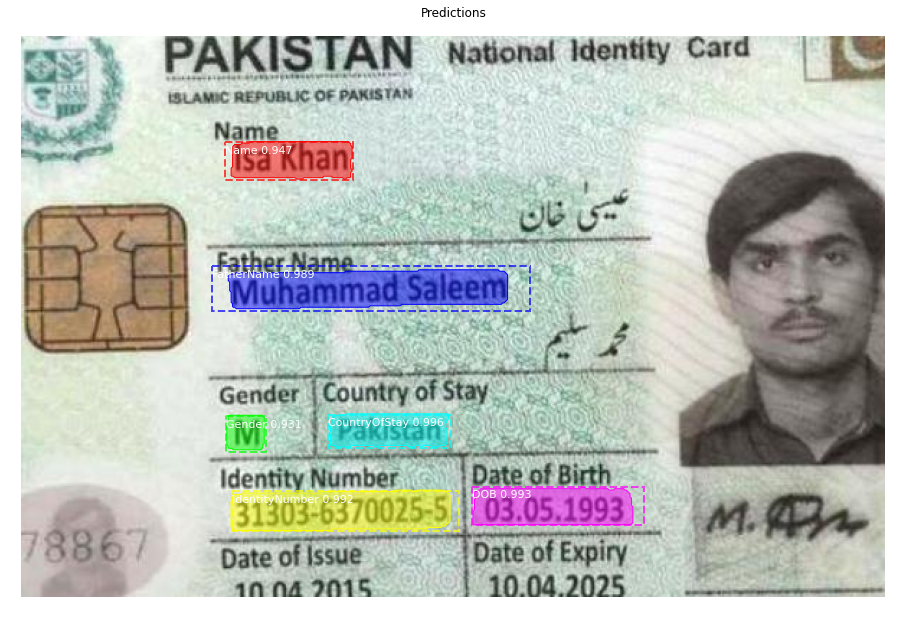

In [ ]:
#detect any image
from keras.preprocessing import image
#c t = aug73_EEGJ75CWkAA5Q_R.jpg, aug71_e7493d0145945d15066a3087ab7ba817
#p t = aug96_news-1466728979-7337.jpg, master_photo.jpg, aug76_dsx_070818_03.jpg
path = "C:\\Users\\Nuzha\\Desktop\\Dataset\\p_cnic\\images\\aug71_e7493d0145945d15066a3087ab7ba817.jpg"

img = image.load_img(path, target_size=(200, 200))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
classes = model.predict(x)
print(classes[0])

if classes[0]<0.5:
    print("CLASSIFICATION RESULT: CNIC image")
    
    img = load_img(path)
    img = np.asarray(img)
    # detecting objects in the image
    results = Cnic_model.detect([img])
    # Display results

    r = results[0]
    visualize.display_instances(img, r['rois'], r['masks'], r['class_ids'], 
                                test_setc.class_names, r['scores'], 
                                title="Predictions")
else:
    print("CLASSIFICATION RESULT: PASSPORT image")

    img = load_img(path)
    img = np.asarray(img)
    # detecting objects in the image
    results = Pass_model.detect([img])
    # Display results

    r = results[0]
    visualize.display_instances(img, r['rois'], r['masks'], r['class_ids'], 
                                test_setp.class_names, r['scores'], 
                                title="Predictions")


In [ ]:
import tensorflow as tf
import numpy as np
from tensorflow import keras
import os
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

In [ ]:
train_cnic_dir = "C:\\Users\\Nuzha\\Desktop\\ds\\train\\cnic"

# Directory with our training grass pictures
train_pass_dir = "C:\\Users\\Nuzha\\Desktop\\ds\\train\\passport"

# Directory with our validation dandelion pictures
valid_cnic_dir = "C:\\Users\\Nuzha\\Desktop\\ds\\test\\cnic"

# Directory with our validation grass pictures
valid_pass_dir = "C:\\Users\\Nuzha\\Desktop\\ds\\test\\passport"

In [ ]:
train_cnic_names = os.listdir(train_cnic_dir)
print(train_cnic_names[:10])

train_pass_names = os.listdir(train_pass_dir)
print(train_pass_names[:10])

validation_cnic_hames = os.listdir(valid_cnic_dir)
print(validation_cnic_hames[:10])

validation_pass_names = os.listdir(valid_pass_dir)
print(validation_pass_names[:10])

['1115361d-c898-4f89-956b-dd1e09f5ece4 (1).jpg', '1486eebd93494b6737978760e702132d.jpg', '189381_1_70996.jpg', '708515c93da74a1ea9731dec6b2112b1.jpg', '716618_376922_h1_updates-1.jpg', '716618_8138261_s1_updates.jpg', '82fb2c2a2fe5a8ff2e8aa01c6e625760.jpg', 'aug0_1486eebd93494b6737978760e702132d.jpg', 'aug0_189381_1_70996.jpg', 'aug0_82fb2c2a2fe5a8ff2e8aa01c6e625760.jpg']
['0-fariha-1537268659-1537281415.jpg', '12915125_10153620705298348_949616896_o_large.jpg', '1443564-farzana-1498249196-400x230.jpeg', '716618_1341073_s2_updates.jpg', 'aug0_0-fariha-1537268659-1537281415.jpg', 'aug0_12915125_10153620705298348_949616896_o_large.jpg', 'aug0_1443564-farzana-1498249196-400x230.jpeg', 'aug0_716618_1341073_s2_updates.jpg', 'aug0_CjEM6QxWUAAfX3I.jpg', 'aug0_dsx_070818_03.jpg']
['aug40_1115361d-c898-4f89-956b-dd1e09f5ece4 (1).jpg', 'aug40_d009bdb7849d0da480496335b72eadcf.jpg', 'aug40_DcnCnWBWsAA27Uq.jpg', 'aug40_e7493d0145945d15066a3087ab7ba817.jpg', 'aug40_EaPm6SHX0Ac0nGA.jpg', 'aug40_EEGJ75

In [ ]:
print('total training cnic images:', len(os.listdir(train_cnic_dir)))
print('total training pass images:', len(os.listdir(train_pass_dir)))
print('total validation cnic images:', len(os.listdir(valid_cnic_dir)))
print('total validation pass images:', len(os.listdir(valid_pass_dir)))

total training cnic images: 886
total training pass images: 886
total validation cnic images: 351
total validation pass images: 326


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Parameters for our graph; we'll output images in a 4x4 configuration
nrows = 4
ncols = 4

# Index for iterating over images
pic_index = 0

In [ ]:
# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)

pic_index += 8
next_cnic_pic = [os.path.join(train_cnic_dir, fname) 
                for fname in train_cnic_names[pic_index-8:pic_index]]
next_pass_pic = [os.path.join(train_pass_dir, fname) 
                for fname in train_pass_names[pic_index-8:pic_index]]

for i, img_path in enumerate(next_cnic_pic + next_pass_pic):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1/255)
validation_datagen = ImageDataGenerator(rescale=1/255)

# Flow training images in batches of 120 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
        "C:\\Users\\Nuzha\\Desktop\\ds\\train",  # This is the source directory for training images
        classes = ['cnic', 'passport'],
        target_size=(200, 200),  # All images will be resized to 200x200
        batch_size=120,
        # Use binary labels
        class_mode='binary')

# Flow validation images in batches of 19 using valid_datagen generator
validation_generator = validation_datagen.flow_from_directory(
        "C:\\Users\\Nuzha\\Desktop\\ds\\test",  # This is the source directory for training images
        classes = ['cnic', 'passport'],
        target_size=(200, 200),  # All images will be resized to 200x200
        batch_size=19,
        # Use binary labels
        class_mode='binary',
        shuffle=False)

Found 1772 images belonging to 2 classes.
Found 677 images belonging to 2 classes.


In [ ]:
import tensorflow as tf
import numpy as np
from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.metrics import roc_auc_score

In [ ]:
model = tf.keras.models.Sequential([tf.keras.layers.Flatten(input_shape = (200,200,3)), 
                                    tf.keras.layers.Dense(128, activation=tf.nn.relu), 
                                    tf.keras.layers.Dense(1, activation=tf.nn.sigmoid)])

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 120000)            0         
_________________________________________________________________
dense (Dense)                (None, 128)               15360128  
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 15,360,257
Trainable params: 15,360,257
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(optimizer = tf.keras.optimizers.Adam(),
              loss = 'binary_crossentropy',
              metrics=['accuracy'])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [ ]:
# history = model.fit(
#       train_generator,
#       steps_per_epoch=8,  
#       epochs=15,
#       verbose=1,
#       validation_data = validation_generator,
#       validation_steps=8)

history = model.fit(train_generator,
      steps_per_epoch=15,  
      epochs=11,
      verbose=1,
      validation_data = validation_generator,
      validation_steps=35)

Epoch 1/11
15/15 [==============================] - 23s 2s/step - loss: 0.4153 - acc: 0.9221 - val_loss: 0.4950 - val_acc: 0.8992
Epoch 2/11
15/15 [==============================] - 16s 1s/step - loss: 0.1259 - acc: 0.9673 - val_loss: 0.4119 - val_acc: 0.9143
Epoch 3/11
15/15 [==============================] - 14s 943ms/step - loss: 0.0638 - acc: 0.9757 - val_loss: 0.4782 - val_acc: 0.9128
Epoch 4/11
15/15 [==============================] - 16s 1s/step - loss: 0.0418 - acc: 0.9836 - val_loss: 0.3869 - val_acc: 0.9113
Epoch 5/11
15/15 [==============================] - 13s 854ms/step - loss: 0.0429 - acc: 0.9876 - val_loss: 0.5546 - val_acc: 0.8902
Epoch 6/11
15/15 [==============================] - 12s 790ms/step - loss: 0.0402 - acc: 0.9870 - val_loss: 0.3487 - val_acc: 0.9173
Epoch 7/11
15/15 [==============================] - 12s 777ms/step - loss: 0.0276 - acc: 0.9932 - val_loss: 0.3590 - val_acc: 0.9158
Epoch 8/11
15/15 [==============================] - 12s 771ms/step - loss: 0.0

In [ ]:
model.evaluate(validation_generator)

36/36 [==============================] - 3s 89ms/step - loss: 0.3653 - acc: 0.9055


[0.3653323106304419, 0.9054653]

In [ ]:
STEP_SIZE_TEST=validation_generator.n//validation_generator.batch_size
validation_generator.reset()
preds = model.predict(validation_generator,
                      verbose=1)

36/36 [==============================] - 3s 95ms/step


In [ ]:
fpr, tpr, _ = roc_curve(validation_generator.classes, preds)

In [ ]:
roc_auc = auc(fpr, tpr)

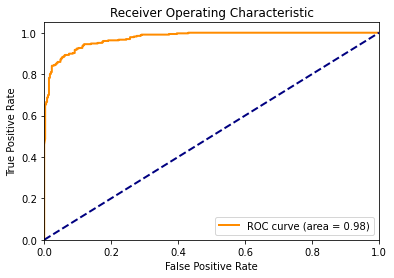

In [ ]:
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from keras.preprocessing import image


[0.]
 is a cnic


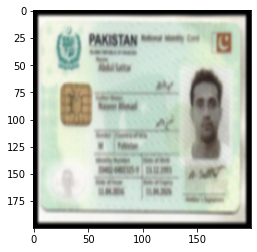

In [ ]:
path = "C:\\Users\\Nuzha\\Desktop\\ds\\test\\cnic\\aug56_189381_1_70996.jpg"
img = image.load_img(path, target_size=(200, 200))
x = image.img_to_array(img)
plt.imshow(x/255.)
x = np.expand_dims(x, axis=0)
classes = model.predict(x)
print(classes[0])
if classes[0]<0.5:
    print(" is a cnic")
else:
    print(" is a passport")